# F&F Lab 1 — Auto Grad

In [227]:
import numbers
#https://maucher.pages.mi.hdm-stuttgart.de/artificial-intelligence/00_Computational_Graphs.html
import numpy
import matplotlib.pyplot as plt

## Steps

1. Read "_How to auto grad_" below, to understand the basic concept.
2. Read "_Solution structure_" below, to understand how the version provided works.
3. Understand the code that has been provided
4. Extend it so you have the  operations needed for linear regression
5. Implement linear regression with gradient descent using your auto grad system. Plot the solution and data on one graph and the history of the loss on another.

## What you should learn

This is about understanding how an automatic differentiation system, such as PyTorch or TensorFlow, works.
It's a tutorial, and shouldn't take too long.
While this may seem somewhat pointless, given the existence of these libraries, the reality is (as you may have already discovered) that it's very easy to write code with them that you think will work, only to discover that it doesn't.
By implementing your own, as simple as it may be, you'll understand internally what such libraries are doing and hence how they can go wrong.
This will make you much better at using these libraries to solve real problems.
It will also give you the understanding you need for if you ever need to extend such a library.

## How to auto grad

Automatic differentiation is just the iterated application of the chain rule: if I have `a = op(b)` for any operation `op` and I know the derivative of `a` with respect to the loss of my objective ($\frac{d\text{loss}}{da}$) and I know the derivative of `op`, ($\frac{da}{db}$) then the chain rule gives us

$$\frac{d\text{loss}}{db} = \frac{d\text{loss}}{da}\frac{da}{db}$$

By doing this repeatedly we can work backwards, from the final calculation of the loss function to any parameter that went into our model.

To do this we need a _computation graph_, i.e. as we perform operations we don't just do what what has been asked of us but also keep a record, a graph of the operations that got us to where we currently are.
The chain rule can hence be used to propagate gradients back throughout this graph (it could be a tree, and that might be easier way to think about it in the first instance, but typically parts get used more than once (e.g. parameters once per data point), turning it into a graph).

This means any auto grad system works in two phases: a forwards pass in which the actual value is calculated, then a backwards pass where gradients are pushed backwards (backprop) to the parameters that we then optimise with gradient descent or a friend.
For the presented system (and PyTorch) the forward pass happens as the lines of code are run, as for normal code; the backwards pass happens when you call `backward()` on your loss function.
This is a recursive function that calls back through the computation graph until it gets to the parameters.

## Solution structure

Firstly, it's impossible to do this sensibly without objects, so this is going to involve object oriented programming.
I've kept it as a simple as possible, so hopefully most of it should just make sense.

The key trick is to have an object rigged so that when you perform standard mathematical operations it instead generates the relevant part of the computation graph and returns that instead.
This is `Scalar` below; it also calculates and stores the computed value as the graph is constructed.

The computation graph is simply a set of nodes that represent mathematical operations, for instance addition, that point to the nodes that they have added together.
These other nodes could be values, further addition nodes or any other mathematical operation.
For the backwards pass each `Node` needs to have the ability to calculate the gradient of it's output with respect to any input so it can then multiply that with the gradient given to it and push that backwards in the graph.
Below there is a parent class, `Node`, with a standard interface that all nodes within the computation graph must provide.
There is then a child class for every operation, plus the `Value` class to support actual values.

One way of doing this is to have some kind of mega class that does all of the operations then have a variant for each mathematical operation.
This gets kinda nasty.
A better approach is to separate out the computation graph from the interface; this has been done below.
`Node` and its children are the computation graph while `Scalar` is the interface.
You actually end up with a bipartite graph in memory: `Scalar` objects always contain a reference to a `Node` object and `Node` objects only contain references to `Scalar` objects.

To really understand the provided code you're going to have to read it…


## Notes

* You will need to implement addition (`__add__`), subtraction (`__sub__`) and multiplication (`__mul__`) to be able to do linear regression. The terms in brackets are the special methods required to override these operations for a class.
* You don't need the `exp` operation, it's just there as an example, so you can see a unary operator alongside the binary operator that is `power` (`**`).
* You may decide to implement a `Sum` node alongside a `sum()` function, as you do have to sum over the data set when calculating the loss function. But it's just as easy to do the loop.
* You don't have operators such as +=, and don't try to implement them: they aren't actually possible, at least not simply, and the reason why is quite subtle. Just use $a = a + b$ instead.
* Implementing linear regression is super simple but has the potential to bite you: unlike systems such as PyTorch there is far less safety here and it could quite happily go horribly wrong. Take particular care to use `detach()` as needed. This may be frustrating, but it's also where you will learn the most.
* Beware `zero_grad()`. It has different semantics to PyTorch and a horrendously evil moustache.
* For the linear regression I initialised both $m$ and $c$ to be 0: 1024 steps with a step size of 1e-3 converged well enough. Standard squared loss with standard gradient descent — don't need anything complicated here.
* In a real system you have the ability to indicate which nodes need gradients calculated and which do not, for reasons of efficiency (`requires_grad` in PyTorch). This has been dropped here for simplicity. Yes, you will be calculating the gradient of your step size with respect to your loss function, whatever that means!

## Auto grad system:

In [228]:
class Node:
    """A node of the computation graph - mostly an interface with little functionality.
    All nodes inherit from it."""
    
    def kind(self):
        """Returns a string identifying the operation or value this node represents.
        Not functionally needed, but a useful representation to have."""
        return 'node'
    
    
    def children(self):
        """Returns a list of the immediate children of this Node in the computation graph.
        These will be Scalar objects, as they need to be wrapped for it to work.
        Not needed to make it work, but allows for visualisation and avoids the
        need to implement zero_grad() for every kind of node."""
        raise NotImplementedError()
    
    def evaluate(self):
        """Evaluates the computation graph at this point, returning the result."""
        raise NotImplementedError()
    
    def zero_grad(self):
        """Zeros the gradient of this node and every child within the computation graph."""
        # Just need to pass the call back; we have the ability to get all of the
        # children, so use it!..
        for child in self.children():
            child.zero_grad()
    
    def backward(self, grad=1):
        """Passes the gradient backwards using the chain rule."""
        raise NotImplementedError()


In [229]:
class Value(Node):
    """Represents a single value."""
    
    def __init__(self, value):
        self._value = float(value)
    
    def kind(self):
        return 'value'
    
    def children(self):
        return []
    
    def evaluate(self):
        return self._value
    
    def backward(self, grad=1):
        pass


In [230]:
class Exp(Node):
    """Calculates the exponent of its parameter."""
    
    def __init__(self, param):
        assert isinstance(param, Scalar)
        self._param = param
    
    def kind(self):
        return 'exp'
    
    def children(self):
        return [self._param]
    
    def evaluate(self):
        return numpy.exp(self._param.value)
    
    def backward(self, grad=1):
        self._param.backward(grad * numpy.exp(self._param.value))


# Nobody want to use the above class directly, hence having a nice wrapper function that
# behaves identically to the normal one...
# (you only do this for operations that Scalar can't automatically sneak in)
def exp(value):
    if not isinstance(value, Scalar):
        value = Scalar(value)
    return Scalar(Exp(value))


In [231]:
class Power(Node):
    """Calculates the first parasmeter to the power of the second parameter."""
    
    def __init__(self, lhs, rhs):
        """lhs = left hand side, rhs = right hand side; represents lhs ** rhs"""
        assert isinstance(lhs, Scalar)
        assert isinstance(rhs, Scalar)
        
        self._lhs = lhs
        self._rhs = rhs
    
    def kind(self):
        return '^'
    
    def children(self):
        return [self._lhs, self._rhs]
    
    def evaluate(self):
        return self._lhs.value**self._rhs.value
    
    def backward(self, grad=1):
        self._lhs.backward(grad * self._rhs.value * self._lhs.value**(self._rhs.value-1))
        
        # This is only defined, at least without using complex numbers, for the lhs being
        # positive; if it isn't give up and break the computation (wrong answer will be generated)...
        # (max is for safety, to avoid numerical overflow)
        if self._lhs.value>0.0:
            d_rhs = grad * self._lhs.value**self._rhs.value * numpy.log(max(self._lhs.value, 1e-256))
            self._rhs.backward(d_rhs)


In [232]:
class Sub(Node):
    """Calculates the first parasmeter to the power of the second parameter."""
    
    def __init__(self, lhs, rhs):
        """lhs = left hand side, rhs = right hand side; represents lhs ** rhs"""
        assert isinstance(lhs, Scalar)
        assert isinstance(rhs, Scalar)
        
        self._lhs = lhs
        self._rhs = rhs
    
    def kind(self):
        return '-'
    
    def children(self):
        return [self._lhs, self._rhs]
    
    def evaluate(self):
        return self._lhs.value-self._rhs.value
    
    def backward(self, grad=1):
        self._lhs.backward(grad * 1)
        self._rhs.backward(grad * -1)
        # This is only defined, at least without using complex numbers, for the lhs being
        # positive; if it isn't give up and break the computation (wrong answer will be generated)...
        # (max is for safety, to avoid numerical overflow)
        # if self._lhs.value>0.0:
        #     d_rhs = grad * self._lhs.value**self._rhs.value * numpy.log(max(self._lhs.value, 1e-256))
        #     self._rhs.backward(d_rhs)


In [233]:
class Add(Node):
    """Calculates the first parasmeter to the power of the second parameter."""
    
    def __init__(self, lhs, rhs):
        """lhs = left hand side, rhs = right hand side; represents lhs ** rhs"""
        assert isinstance(lhs, Scalar)
        assert isinstance(rhs, Scalar)
        
        self._lhs = lhs
        self._rhs = rhs
    
    def kind(self):
        return '+'
    
    def children(self):
        return [self._lhs, self._rhs]
    
    def evaluate(self):
        return self._lhs.value+self._rhs.value
    
    def backward(self, grad=1):
        self._lhs.backward(grad * 1)
        self._rhs.backward(grad * 1)


In [234]:
class Mul(Node):
    """Calculates the first parasmeter to the power of the second parameter."""
    
    def __init__(self, lhs, rhs):
        """lhs = left hand side, rhs = right hand side; represents lhs ** rhs"""
        assert isinstance(lhs, Scalar)
        assert isinstance(rhs, Scalar)
        
        self._lhs = lhs
        self._rhs = rhs
    
    def kind(self):
        return '-'
    
    def children(self):
        return [self._lhs, self._rhs]
    
    def evaluate(self):
        return self._lhs.value-self._rhs.value
    
    def backward(self, grad=1):
        self._lhs.backward(grad * self._rhs.value)
        self._rhs.backward(grad * self._lhs.value)


In [235]:
class Scalar:
    """This is a conveniance wrapper around nodes, that exists so everything behaves sensibly.
    In PyTorch this is exactly equivalent to the Tensor class, except it only does one value at
    a time, rather than an nD array, hence the name Scalar, because that's all it represents.
    It's main purpose is to override operations, so when you do maths on it the
    right type of node is created and it returns a new scalar with the expected
    computation graph."""
    
    def __init__(self, node, name = None):
        """Lets you create a scalar, either from a number or from a Node. You can also provide
        a name to communicate what the Scalar represents."""
        # As a matter of conveniance, and to copy PyTorch, if you pass in a number it is converted...
        if isinstance(node, numbers.Number):
            node = Value(node)
        
        assert isinstance(node, Node)
        
        self._node = node
        self._name = name
        
        self._value = node.evaluate()
        self._grad = 0.0
    
    
    @property # @property decorator means this acts as a read only variable; good for safety
    def kind(self):
        """Returns the kind of operation it represents; informational."""
        return self._node.kind()
    
    @property
    def name(self):
        """If a name has been set this provides it; None if a name has not been set."""
        return self._name
    
    @property
    def value(self):
        """Returns the value of the Scalar."""
        return self._value
    
    @property
    def grad(self):
        """Returns the gradient of the Scalar."""
        return self._grad
    
    
    @property
    def node(self):
        """Gives you access to the computation graph wrapped by the Scalar. Not
        needed for normal use."""
        return self._node
    
    
    def zero_grad(self):
        """Zeroes all gradients in the computation graph; typically used at the start of
        each step of optimisation right before backward is called. Note that this operates
        differently to the approach in PyTorch, which is the better approach. This is
        inefficient and has a nasty gotcha: it's easy to accidentally call it when you're
        parameters are not part of the computation graph."""
        self._grad = 0.0
        self._node.zero_grad()
    
    
    def backward(self, grad=1):
        """Sends a gradient backwards through the computatiuon graph, updating all values with
        respect to the gradient here. The parameter defaults to 1, because the gradient of a
        variable with respect to itself is 1, and this is typically called on just the final
        loss to push back to all parameters their gradient with respect to the loss."""
        
        # Update this nodes record of its gradient; it's += because the computation graph
        # will typically reach the same node through multiple routes...
        self._grad += grad
        
        # Continue to send the gradient backwards, to update all of the graph...
        self._node.backward(grad)
    
    
    def detach(self):
        """The problem with computation graphs is that they just keep growing, until you
        run out of memory. For this reason care has to be taken to cull them back, before
        they overwhelm you. The detach operation does exactly that: it detaches from the
        computation graph that feeds into this Scalar, by replacing the Node with the
        dead end that is a Value()."""
        self._node = Value(self._value)


    def __pow__(self, rhs):
        """This method gets called when you call self**rhs and self is an instance of this class."""
        if not isinstance(rhs, Scalar):
            rhs = Scalar(rhs)
        return Scalar(Power(self, rhs))
    
    def __add__(self, rhs):
        """This method gets called when you call self+rhs and self is an instance of this class."""
        if not isinstance(rhs, Scalar):
            rhs = Scalar(rhs)
        return Scalar(self.value + rhs.value)
    
    def __sub__(self, rhs):
        """This method gets called when you call self+rhs and self is an instance of this class."""
        if not isinstance(rhs, Scalar):
            rhs = Scalar(rhs)
        return Scalar(Sub(self,rhs))
    
    def __mul__(self, rhs):
        """This method gets called when you call self+rhs and self is an instance of this class."""
        if not isinstance(rhs, Scalar):
            rhs = Scalar(rhs)
        return Scalar(self.value * rhs.value)
    
    def __repr__(self):
        """This is what you get when you print this object."""
        return f'Scalar(value={self.value:.6f}, grad={self.grad:.6f}, kind={self.kind}, name={self.name})'
    
    
    def equation(self, use_names = True):
        """The computation graph is rather nice in that you can use it to generate an equation
        for what has been computed. You can ignore this code, but this method can be useful
        (if far too bracket happy) for debugging."""
        
        if isinstance(self._node, Value):
            if self._name is not None and use_names:
                return self._name
            else:
                return f'{self.value:.6f}'
        
        children = self._node.children()
        if len(self.kind)==1 and len(children)==2:
            # This formats binary operators as expected...
            return f'({children[0].equation(use_names)}){self.kind}({children[1].equation(use_names)})'
        
        else:
            # Everything else can look like a function...
            return self.kind + '(' + ','.join([child.equation(use_names) for child in children]) + ')'
        

## Test code:

In [236]:
# Gradient of a value with respect to itself better be 1!..
print('value:')
a = Scalar(4)
a.backward()
print(a)
print()


# Exponential is pretty straight forward...
print('exp:')
a = Scalar(4)
b = exp(a)
b.backward()
print(a)
print(b.equation())
print(b)
print()


# Power - gradients should be 4 and 2.77...
print('power:')
a = Scalar(2, 'a')
b = Scalar(2, 'b')
c = a**b
c.backward()

print(a)
print(b)
print(c.equation())
print(c)
print()


# Gradients through a sum don't change...
print('addition:')
a = Scalar(2, 'a')
b = Scalar(2, 'b')
c = a + b
c.backward()

print(a)
print(b)
print(c.equation())
print(c)
print()


# Subtraction will flip the gradient of the second term...
print('subtraction:')
a = Scalar(2, 'a')
b = Scalar(2, 'b')
c = a - b
c.backward()

print(a)
print(b)
print(c.equation())
print(c)
print()


# Multiplication is more fun - gradient is scaled by the other value...
print('multiplication:')
a = Scalar(0.5, 'a')
b = Scalar(2, 'b')
c = a * b
c.backward()

print(a)
print(b)
print(c.equation())
print(c)
print()


value:
Scalar(value=4.000000, grad=1.000000, kind=value, name=None)

exp:
Scalar(value=4.000000, grad=54.598150, kind=value, name=None)
exp(4.000000)
Scalar(value=54.598150, grad=1.000000, kind=exp, name=None)

power:
Scalar(value=2.000000, grad=4.000000, kind=value, name=a)
Scalar(value=2.000000, grad=2.772589, kind=value, name=b)
(a)^(b)
Scalar(value=4.000000, grad=1.000000, kind=^, name=None)

addition:
Scalar(value=2.000000, grad=0.000000, kind=value, name=a)
Scalar(value=2.000000, grad=0.000000, kind=value, name=b)
4.000000
Scalar(value=4.000000, grad=1.000000, kind=value, name=None)

subtraction:
Scalar(value=2.000000, grad=1.000000, kind=value, name=a)
Scalar(value=2.000000, grad=-1.000000, kind=value, name=b)
(a)-(b)
Scalar(value=0.000000, grad=1.000000, kind=-, name=None)

multiplication:
Scalar(value=0.500000, grad=0.000000, kind=value, name=a)
Scalar(value=2.000000, grad=0.000000, kind=value, name=b)
1.000000
Scalar(value=1.000000, grad=1.000000, kind=value, name=None)



## Linear regression:

In [237]:
# Some data - not a lot as this code is not very efficient...
train_x = [1.0, 2.0, 3.0, 4.0]
train_y = [2.2, 2.5, 2.4, 2.7]

# Initialise weights and bias
w = Scalar(0.0, name='w')
b = Scalar(0.0, name='b')

# Learning rate
alpha = 0.001

# iterations
n = 100

# Training loop
for _ in range(n):
    for x,y in zip(train_x, train_y):
        x = Scalar(Value(x))
        y = Scalar(Value(y))

        #Forward pass: compute predicted y abd loss
        y_pred = Scalar(Add(Scalar(Mul(w,x)),b))
        loss = Scalar(Power(Scalar(Sub(y_pred,y)),Scalar(2)))

        #Backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()

        #Update weights and bias
        w = Scalar(Sub(w,Scalar(alpha*w.grad)))
        b = Scalar(Sub(b,Scalar(alpha*b.grad)))

        #Zero the gradients
        w.zero_grad()
        b.zero_grad()

print(f'w: {w.value}, b: {b.value}')



w: 3.927390270622621, b: 1.1174789559372718


In [238]:
# Use skitlearn to check the result
from sklearn.linear_model import LinearRegression
import numpy as np

model = LinearRegression()
"""
array([[1.],
       [2.],
       [3.],
       [4.]])
"""
model.fit(np.array(train_x).reshape(-1,1),train_y)
true_w = model.coef_[0]
true_b = model.intercept_
print(f'true_w: {true_w}, true_b: {true_b}')

true_w: 0.13999999999999999, true_b: 2.1


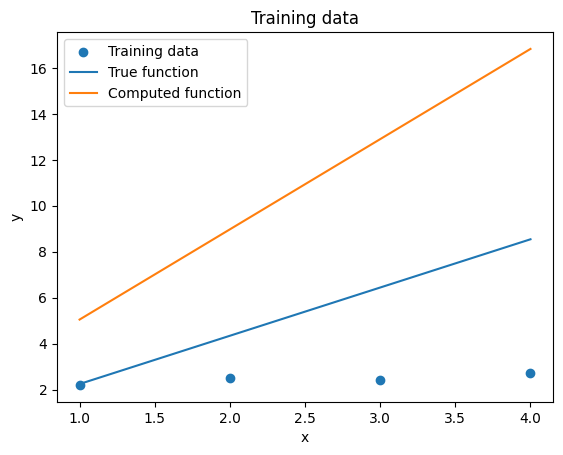

In [245]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the points
plt.scatter(train_x, train_y, label='Training data')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data')

# Generate a range of x values
x_values =  np.array([1.0, 2.0, 3.0, 4.0])

# # Compute the true y values
true_y_values = [0.13999999999999999 + 2.1 * x for x in x_values]

# Compute the predicted y values
pred_y_values = [w.value * x + b.value for x in x_values]

# Plot the true function
plt.plot(x_values, true_y_values, label='True function')

# Plot the computed function
plt.plot(x_values, pred_y_values, label='Computed function')

# Add a legend
plt.legend()

# Show the plot
plt.show()